# PART 1: Car Data Cleaning

---

## Table of Contents
1. Data Gathering
2. Cleaning the Data & Dealing with Outliers
3. Feature Engineering & Visualizing Relationships
4. Normalization?

**++++++++
I want to try one more encoding scheme then start putting together the final products.
++++++++**

CHECK OUT DISTRIBUTION OF DATA

RELAION BETWEEN EVERYTHING



#### NOTE: FIND WAY TO LINK TABLE OF CONTENTS

---

<br />





## 1. Data Gathering

---

My original plan for this project was to use data collected from one of my previous projects (https://github.com/ryanirl/CraigslistScraper) but rather than spending weeks gathering a large dataset (100k+ entries) I found this dataset (https://www.kaggle.com/austinreese/craigslist-carstrucks-data) on kaggle which has already scrapped some 400k+ entries of data. Huge thanks to the person who has been compiling this data for this amount of time. If you are following along on your own I would highly recommend downloading this dataset from kaggle as it's to large to throw on GitHub, though I will most likely have my cleaned data posted to github in a zip file.



In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from scipy import stats

# REMOVE BEFORE UPLOAD -----
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
# --------------------------

import category_encoders as ce
from sklearn.model_selection import train_test_split
import sklearn

# I think I can minimize this down a bit during pipeline
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

In [2]:
# Reading in the Data
df = pd.read_csv('vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

<br />

## 2. Cleaning the Data & Dealing with Outliers

---

Of the 25 features included in the dataset we are only interested in features with strong correlation to price. It's easy to see that - **posting_date, county, image_url, region_url, region_url, description, id, url, region, VIN, long, and lat** - won't have a strong correlation to the price and can therefore be removed.

In addition, because we are given Manufacturer I am going to remove Model because working with this feature is too unconsistant and subjective to human input error (EX: GIVE EX). If we had millions of entries of data and if this data wasn't collected on craigslist then this would be an indispensible feature but because "Model" is an open field entry in craigslst then this feature would only confuse our model **ELEBORATE ON THIS WITH A PICTURE OF THE FIELD TOO**. This leaves us with 14 Key Features.


### Important Features of the Dataset:

**Numeric Features:**
- Price           
- Year  
- Odometer



**Categorical Features:**

Nominal:
- Manufacturer 
- Type 
- Paint Color
- Transmission
- Drive
- Fuel
- State

Ordinal:
- Condition                         
- Cylinders           
- Size               
- Title Status ( Ordinal for example because "salvage_title" < "clear" )


---



In [3]:
# List of "Bad Features" whos values aren't correlated with price. 
bad_features = ['posting_date', 'county', 'image_url', 'region_url', 'region_url', 'description',
                'id', 'url', 'model', 'region', 'VIN', 'long', 'lat']

# Remeving these bad features from out Dataset.
df.drop(bad_features, inplace=True, axis=1)





## Outliers

---

When dealing with automobile data from Craiglist we are ought to get many outliers. For example, look at the code below, the vanilla Dataset has 32,895 rows with cars listed at 0 dollars, this is plenty of enough values to skew our results and so we must deal with outliers.



In [4]:
df.price.value_counts().head()

0       32895
6995     3169
7995     3129
9995     2867
8995     2837
Name: price, dtype: int64

<br />

---


To start, we have 3 numeric features in which human error can introduct outliers. These features are Price, Odometer, and Year. To simplify our data and remove outliers I could do something like finding the z-score of each feature then remove outliers that way, though I feel as if because of the number of 0's we potentially have out z-score itself is going to be biased toward the outliers. 

**Solution:** The easiest way around this is just to restrict the domains themself.



In [4]:
# Removing any cars that don't have price between 500 < x < 80000
df = df[df['price'] > 500]
df = df[df['price'] < 80000]

# Removing any cars that don't have odometer between 500 < x < 300000
df = df[df['odometer'] < 300000]
df = df[df['odometer'] > 500]

# Removing any cars that don't have year between 2020 < x < 2000
df = df[df['year'] < 2020]
df = df[df['year'] > 2000]

len(df.index)

327544

<br />


We have removed over 100,000 entries which lie beyond this domain restriction.



## NaN Values

---

Later in this Notebook I will Target encode the majority of features besides Manufacturer. This will deal with the NaN values on it's own by encoding them as if they are they're own domain. 

I let this happen because if I were to just remove them then out dataset actually shrinks to just above 100k entries.

**LOOK INTO METHODS OF IMPUTATION**



In [12]:
# TALK ABOUT WHY THIS INCREASES R2 SCORE BY 7% 

df.dropna(subset = ["odometer", "cylinders"], inplace=True)

df.fillna("0", inplace=True)

len(df.index)

195121

<br />

## 3. Feature Engineering

---

We have 11 categorical features that need to be represented numerically. 

Target Encoding for everything but Manufacturer

One-Hot Encoding for Manufacturer

Pipeline each one of these

I CANNOT MAKE GUESSES. MAKE HYPOTHESIS THEN PROVE USING DATA.

NOTE: Check correlation between price / year / and transmission (manual / auto) using bar graph


In [6]:
x_1 = df[['year', 'transmission', 'price', 'fuel', 'title_status', 'type', 'drive', 'manufacturer']]
x_sample_1 = x_1.dropna().sample(5000)

filtered_year = x_sample_1[x_sample_1['year'] > 2010] 
filtered_year = filtered_year[filtered_year['year'] < 2020] 
filtered_year = filtered_year[filtered_year['price'] < 60000] 

type_data = filtered_year[filtered_year['year'] < 2013] 

<AxesSubplot:>

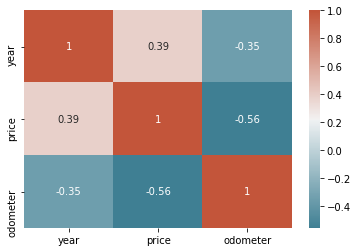

In [5]:
df
x_2 = df[['year', 'price', 'odometer']]
# calculate correlation matrix
corr = x_2.corr()# plot the heatmap
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sb.diverging_palette(220, 20, as_cmap=True))

In [6]:
Y = df['price']

df.drop('price', inplace=True, axis=1)

In [7]:
# ------------- Target Encoding ----------------- #

# Complies Target Encoding for Features (NOT INCLUDING "Manufacturer")
target_encode = ce.TargetEncoder(cols = ['transmission', 'fuel', 'title_status', 'type', 'drive', 'state', 
                                         'condition', 'size', 'cylinders', 'paint_color']).fit(df, Y)

# Applies Target Endcoding and Transforms Dataframe
df = target_encode.transform(df)



# ------------- One-Hot Encoding ---------------- #

# Builds One-Hot Encoding 
one_hot_encoding = pd.get_dummies(df.manufacturer)

# Drops Categorical Manufactural Feature
df.drop('manufacturer', inplace=True, axis=1)

# Adds One-Hot Encoding of Manufacturers to Dataframe
df = pd.concat([df, one_hot_encoding], axis=1)

df

/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,...,pontiac,porsche,ram,rover,saturn,subaru,tesla,toyota,volkswagen,volvo
27,2014.0,19118.188276,24680.853104,16439.126532,57923.0,18036.783259,29745.373317,18578.572967,19893.045241,27623.847865,...,0,0,0,0,0,0,0,0,0,0
28,2010.0,19118.188276,24680.853104,16439.126532,71229.0,18036.783259,29745.373317,18578.572967,19893.045241,27623.847865,...,0,0,0,0,0,0,0,0,0,0
30,2017.0,19118.188276,24680.853104,16439.126532,41124.0,18036.783259,29745.373317,18578.572967,19893.045241,27623.847865,...,0,0,0,0,0,0,0,1,0,0
31,2013.0,14891.294846,18524.685354,16439.126532,128000.0,18036.783259,16325.936820,20367.152743,17395.888563,26280.056170,...,0,0,0,0,0,0,0,0,0,0
32,2012.0,19118.188276,24680.853104,16439.126532,68696.0,18036.783259,29745.373317,21921.540501,19893.045241,27623.847865,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426864,2016.0,19118.188276,18524.685354,16439.126532,53475.0,18036.783259,16325.936820,18578.572967,19893.045241,16297.461945,...,0,0,0,0,0,0,0,1,0,0
426866,2016.0,19118.188276,24680.853104,16439.126532,55612.0,18036.783259,16325.936820,20367.152743,19893.045241,27573.931443,...,0,0,0,0,0,0,0,0,0,0
426874,2018.0,19118.188276,18524.685354,16439.126532,30814.0,18036.783259,16325.936820,20367.152743,19893.045241,12101.790448,...,0,0,0,0,0,0,0,0,0,0
426875,2019.0,19118.188276,18524.685354,16439.126532,32226.0,18036.783259,29745.373317,10554.320597,19893.045241,12101.790448,...,0,0,0,0,0,0,0,0,0,0





## Normalizing the Data

---

</br>

## Regression

---

#### Models to Test:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. K-Nearest Regressor

### 1. Random Forest



In [ ]:
Y = df['price']

df.drop('price', inplace=True, axis=1)

In [10]:
df = stats.zscore(df)


In [8]:
# NEED TO COLLECT SOME ADDITIONAL INFORMATION FOR TESTING

X_train, X_test, y_train, y_test = train_test_split(df, Y, train_size=0.999, test_size=0.001, random_state=42)
››
# RFR_model = RandomForestRegressor(bootstrap=True, max_features=0.75, min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state = 42)
RFR_model = RandomForestRegressor(random_state = 1) # THIS CURRENTLY PERFORMS BEST - TEST AGAINST OTHERS THOUGH
# RFR_model = RandomForestRegressor(bootstrap=True, max_features=0.15000000000000002, min_samples_leaf=2, min_samples_split=19, n_estimators=100)

RFR_model.fit(X_train, y_train)

results = RFR_model.predict(X_test)

In [9]:
# results = RFR_model.predict(X_test)

test = y_test.to_numpy()
# cleared blank cylinders and got .96! r2 WTFTFTFTF
print(sklearn.metrics.mean_squared_error(test, results, sample_weight=None, multioutput='uniform_average', squared=False))
print(sklearn.metrics.mean_absolute_error(test, results, sample_weight=None, multioutput='uniform_average'))
print(sklearn.metrics.r2_score(test, results, sample_weight=None, multioutput='uniform_average'))

2529.1530587612447
1314.4752849466292
0.9615567575353761


In [28]:
df

array([[ 0.4545862 ,  1.53330688,  0.69667506, ...,  0.74245584,
         0.83019862,  1.5703616 ],
       [ 0.06109884,  0.46665971,  0.69667506, ...,  0.74245584,
         0.83019862,  1.5703616 ],
       [ 1.04481722,  0.46665971,  0.69667506, ...,  0.74245584,
         0.83019862,  1.5703616 ],
       ...,
       [ 0.84807355,  0.64684109,  0.69667506, ...,  0.4314488 ,
         0.83019862, -0.94216134],
       [ 0.94644539, -0.8623742 ,  0.69667506, ..., -1.60086041,
         0.83019862, -0.94216134],
       [ 0.84807355,  0.64684109,  0.69667506, ..., -1.60086041,
         0.83019862, -0.94216134]])

<AxesSubplot:>

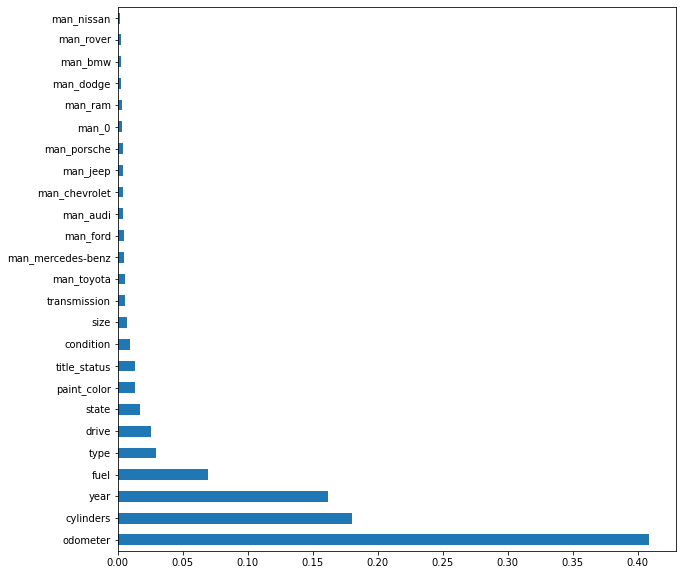

In [11]:
feat_importances = pd.Series(RFR_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, train_size=0.999, test_size=0.001, random_state=42)
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsRegressor()

In [14]:
results = neigh.predict(X_test)
test = y_test.to_numpy()

print(sklearn.metrics.mean_squared_error(test, results, sample_weight=None, multioutput='uniform_average', squared=False))
print(sklearn.metrics.mean_absolute_error(test, results, sample_weight=None, multioutput='uniform_average'))
print(sklearn.metrics.r2_score(test, results, sample_weight=None, multioutput='uniform_average'))

4503.293606008585
2837.3315068493152
0.8574439787794496


In [18]:
results

array([ 4348. ,  6199.4,  7560. , 22728. , 38590. ,  4130. , 32500. ,
       12176.8, 18876.8,  5728. ,  5259. , 10779. , 34495. ,  8259. ,
        4959.8, 19674.6,  9449. , 31052. , 10755.4,  8419.8,  7596.8,
        5015.2, 14995. , 35990. , 39590. , 41002.4,  4720. , 11736. ,
       10711. ,  8797. ,  2773.2, 11413.8,  9518. ,  5780. ,  5995. ,
        5064.2,  6938. , 25990. ,  4678.8,  2190. ,  5730. , 16855.6,
        1475. , 10997.4, 17782.6, 11379.8,  3130. , 26199. , 16376.2,
       38710. , 31458. ,  8400. ,  5288. ,  9035. , 17089.4,  9677.2,
       39590. ,  7096.8,  2600. , 12159. , 34590. ,  8106.8,  3920. ,
       10974.8,  5854.6, 53990. , 59985.6, 14152.4,  9397.8,  8700. ,
       40958. , 15496. , 10819. , 18866. ,  7762. ,  5350. ,  5909. ,
        3037.6,  6969.6, 18599.2,  3450. , 24590. ,  8988. , 29990. ,
        7517. , 24798.8, 26659. ,  3160. , 30166.8, 21331. , 26296. ,
        6634. , 44590. ,  6860. , 21990. ,  8490. , 16400. ,  3540. ,
       35590. , 1618

In [19]:
test

array([ 5000,  3799,  7500, 22995, 38590,  3500, 32500, 12525, 18999,
        5300,  4200, 11500, 33999,  8000,  5000, 21495,  9750, 28900,
       10995,  7900,  7499,  4500, 14995, 35990, 39590, 39990,  4000,
       11900, 10995,  9000,   756, 10800, 10000,  6500,  6500,  4990,
        7500, 25990,  5000,  2500,  7500, 16999,  1000, 10995, 19000,
       12500,  3475, 26999, 15990, 39990, 31000,  9000,  3900,  8999,
       16999,  9899, 39590,  6400,  2200, 12950, 34590,  8100,  5950,
       11995,  6980, 53990, 61500, 13995,  9995,  7900, 39871, 14900,
       10200, 19995,  7996,  4500,  6500,  5000,  8500, 17900,  1000,
       24590,  8995, 29990,  9995, 24995, 26500,  2900, 29900, 20789,
       22000,  6998, 44590,  6995, 23990,  8475, 15995,  2000, 35590,
       16990, 34990, 29990, 21999,  3900,  7500,  5500,  8999, 10950,
       34088, 27990,  7900, 18980,  8495, 28590,  7950, 17500,  6975,
        5500, 32999, 18999, 44590, 33991,   699, 13999, 28150,  3950,
       12495, 50000,

In [33]:
df

array([[ 0.4545862 ,  0.69667506,  1.11884899, ..., -0.30414142,
        -0.14309252, -0.07951549],
       [ 0.06109884,  0.69667506,  1.11884899, ..., -0.30414142,
        -0.14309252, -0.07951549],
       [ 1.04481722,  0.69667506,  1.11884899, ..., -0.30414142,
        -0.14309252, -0.07951549],
       ...,
       [ 0.84807355,  0.69667506,  0.24887696, ..., -0.30414142,
        -0.14309252, -0.07951549],
       [ 0.94644539,  0.69667506,  0.24887696, ..., -0.30414142,
        -0.14309252, -0.07951549],
       [ 0.84807355,  0.69667506,  0.24887696, ..., -0.30414142,
        -0.14309252, -0.07951549]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, Y, train_size=0.999, test_size=0.001, random_state=42)
model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)
results = neigh.predict(X_test)
test = y_test.to_numpy()

print(sklearn.metrics.mean_squared_error(test, results, sample_weight=None, multioutput='uniform_average', squared=False))
print(sklearn.metrics.mean_absolute_error(test, results, sample_weight=None, multioutput='uniform_average'))
print(sklearn.metrics.r2_score(test, results, sample_weight=None, multioutput='uniform_average'))

In [ ]:
# Create function for loss